This page was created from a Jupyter notebook. The original notebook can be found [here](https://github.com/klane/databall/blob/master/notebooks/model-performance.ipynb). It compares model performance using various algorithms. First we must import the necessary installed modules.

In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

Next we need to import a few local modules.

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from databall.database import Database
from databall.plotting import format_538, plot_confusion_matrix
from databall.profit import profit
from databall.simulate import simulate

As before, apply the FiveThirtyEight plot style.

In [3]:
plt.style.use('fivethirtyeight')

# Data

Next we define the box score stats used during [feature selection](feature-selection.md) and [parameter tuning](parameter-tuning.md).

In [4]:
stats = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK']
stats = ['TEAM_' + s for s in stats] + ['POSSESSIONS']
stats += [s + '_AWAY' for s in stats] + ['HOME_SPREAD']
var_predict = 'HOME_SPREAD_WL'

Then we load the dataset in the same manner as before.

In [5]:
database = Database('../data/nba.db')
games = database.betting_stats(window=10)
games = games.loc[games.SEASON>=2006, stats + ['SEASON', 'GAME_DATE', var_predict]].dropna()

# Logistic Regression

The first model evaluation looks at a logistic regression model using the optimal parameters obtained during [parameter tuning](parameter-tuning.md). The code below creates and model, predicts the 2016 season, and calculates different metrics. It then displays a nicely formatted [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix). It uses a slightly modified version of the function found [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py). Logistic regression only predicts about 52% of games correctly. The confusion matrix shows that the model performs much better at predicting home wins, where it correctly predicted over 60% of games in which the home team won against the spread. However, it struggles to predict home losses, where it gets less than half of the games right. A [classification report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) is printed below the confusion matrix that displays metrics such as precision and recall. All the classifiers use 50% probability as the threshold for switching between classes since this is a binary classification problem.

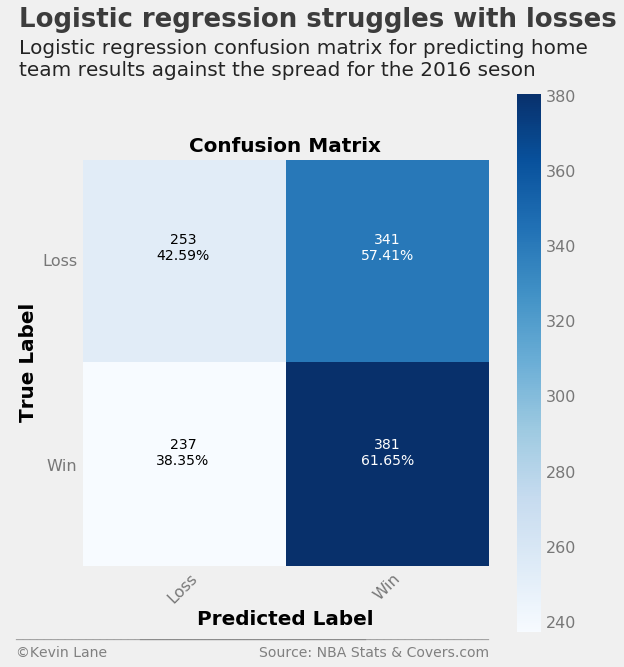

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.516     0.426     0.467       594
        Win      0.528     0.617     0.569       618

avg / total      0.522     0.523     0.519      1212

Correctly predicted 52.31% of games


In [6]:
model = LogisticRegression(C=0.0001943920615336294, penalty='l2',
                           fit_intercept=True, intercept_scaling=134496.71823111628)
output_log = simulate(model, games, 2016, stats, var_predict)
days_log, per_log, profit_log = profit(output_log, var_predict=var_predict, bet_amount=100)
cm = confusion_matrix(output_log.HOME_SPREAD_WL, output_log.HOME_SPREAD_WL_PRED)

fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, ['Loss', 'Win'], fig=fig)

title = 'Logistic regression struggles with losses'
subtitle = '''Logistic regression confusion matrix for predicting home
team results against the spread for the 2016 seson'''
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, ax=fig.axes,
           xoff=(-0.18, 1.02), yoff=(-0.17, -0.22), toff=(-.15, 1.32), soff=(-0.15, 1.2),
           n=50, bottomtick=np.nan)
plt.show()

print('_' * 52)
print(classification_report(output_log.HOME_SPREAD_WL, output_log.HOME_SPREAD_WL_PRED,
                            target_names=['Loss', 'Win'], digits=3))
print('Correctly predicted {:.2f}% of games'
      .format(accuracy_score(output_log.HOME_SPREAD_WL, output_log.HOME_SPREAD_WL_PRED) * 100))

# Support Vector Machine

The support vector machine has the opposite characteristics to the logistic regression model where it performs much better at predicting home team losses against the spread. Overall it performs slightly worse than logistic regression by predicting about 51.5% of games correctly.

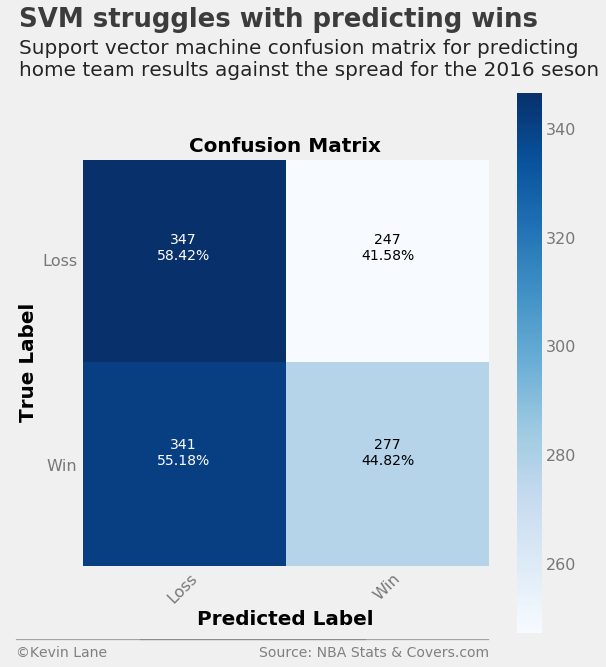

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.504     0.584     0.541       594
        Win      0.529     0.448     0.485       618

avg / total      0.517     0.515     0.513      1212

Correctly predicted 51.49% of games


In [7]:
model = LinearSVC(C=3.2563857398383885e-06, loss='squared_hinge',
                           fit_intercept=True, intercept_scaling=242.79319791592195)
output_svm = simulate(model, games, 2016, stats, var_predict)
days_svm, per_svm, profit_svm = profit(output_svm, var_predict=var_predict, bet_amount=100)
cm = confusion_matrix(output_svm.HOME_SPREAD_WL, output_svm.HOME_SPREAD_WL_PRED)

fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, ['Loss', 'Win'], fig=fig)

title = 'SVM struggles with predicting wins'
subtitle = '''Support vector machine confusion matrix for predicting
home team results against the spread for the 2016 seson'''
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, ax=fig.axes,
           xoff=(-0.18, 1.02), yoff=(-0.17, -0.22), toff=(-.15, 1.32), soff=(-0.15, 1.2),
           n=50, bottomtick=np.nan)
plt.show()

print('_' * 52)
print(classification_report(output_svm.HOME_SPREAD_WL, output_svm.HOME_SPREAD_WL_PRED,
                            target_names=['Loss', 'Win'], digits=3))
print('Correctly predicted {:.2f}% of games'
      .format(accuracy_score(output_svm.HOME_SPREAD_WL, output_svm.HOME_SPREAD_WL_PRED) * 100))

# Random Forest

The random forest model has a similar problem to the support vector machine where it performs better at predicting home losses than wins. However, it is essentially a coin flip at predicting home wins, whereas the support vector machine leans more toward predicting a home loss in all cases. As a result, the random forest outperforms the support vector machine and even overtakes the logistic regression model.

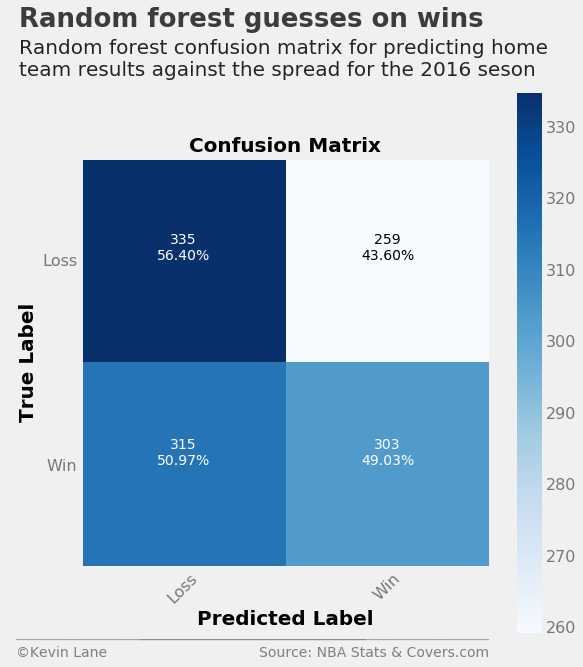

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.515     0.564     0.539       594
        Win      0.539     0.490     0.514       618

avg / total      0.528     0.526     0.526      1212

Correctly predicted 52.64% of games


In [8]:
model = RandomForestClassifier(n_estimators=34, criterion='entropy', class_weight='balanced',
                               bootstrap=True, random_state=8)
output_rf = simulate(model, games, 2016, stats, var_predict)
days_rf, per_rf, profit_rf = profit(output_rf, var_predict=var_predict, bet_amount=100)
cm = confusion_matrix(output_rf.HOME_SPREAD_WL, output_rf.HOME_SPREAD_WL_PRED)

fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, ['Loss', 'Win'], fig=fig)

title = 'Random forest guesses on wins'
subtitle = '''Random forest confusion matrix for predicting home
team results against the spread for the 2016 seson'''
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, ax=fig.axes,
           xoff=(-0.18, 1.02), yoff=(-0.17, -0.22), toff=(-.15, 1.32), soff=(-0.15, 1.2),
           n=50, bottomtick=np.nan)
plt.show()

print('_' * 52)
print(classification_report(output_rf.HOME_SPREAD_WL, output_rf.HOME_SPREAD_WL_PRED,
                            target_names=['Loss', 'Win'], digits=3))
print('Correctly predicted {:.2f}% of games'
      .format(accuracy_score(output_rf.HOME_SPREAD_WL, output_rf.HOME_SPREAD_WL_PRED) * 100))

# Neural Network

The neural network again performs better at predicting home losses against the spread than wins, where it correctly predicts almost 65% of games correctly. It gets most of the home wins wrong, but its accuracy with home losses is enough to improve on the random forest accuracy by about 1%.

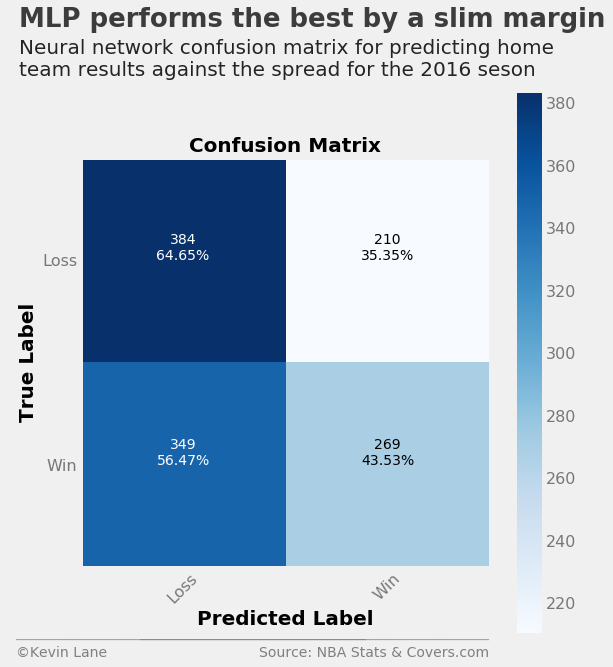

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.524     0.646     0.579       594
        Win      0.562     0.435     0.490       618

avg / total      0.543     0.539     0.534      1212

Correctly predicted 53.88% of games


In [9]:
model = MLPClassifier(alpha=5.700733605522687e-06, hidden_layer_sizes=49,
                      solver='lbfgs', activation='relu', max_iter=500, random_state=8)
output_mlp = simulate(model, games, 2016, stats, var_predict)
days_mlp, per_mlp, profit_mlp = profit(output_mlp, var_predict=var_predict, bet_amount=100)
cm = confusion_matrix(output_mlp.HOME_SPREAD_WL, output_mlp.HOME_SPREAD_WL_PRED)

fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, ['Loss', 'Win'], fig=fig)

title = 'MLP performs the best by a slim margin'
subtitle = '''Neural network confusion matrix for predicting home
team results against the spread for the 2016 seson'''
format_538(fig, 'NBA Stats & Covers.com', title=title, subtitle=subtitle, ax=fig.axes,
           xoff=(-0.18, 1.02), yoff=(-0.17, -0.22), toff=(-.15, 1.32), soff=(-0.15, 1.2),
           n=50, bottomtick=np.nan)
plt.show()

print('_' * 52)
print(classification_report(output_mlp.HOME_SPREAD_WL, output_mlp.HOME_SPREAD_WL_PRED,
                            target_names=['Loss', 'Win'], digits=3))
print('Correctly predicted {:.2f}% of games'
      .format(accuracy_score(output_mlp.HOME_SPREAD_WL, output_mlp.HOME_SPREAD_WL_PRED) * 100))

# Model Comparison

The plots below show cumulative accuracy and profit for the four models throughout the 2016 season. The models will naturally be ordered by the accuracies above at the season's end, but it is interesting to see the progression. The neural network was the highest earning during most of the season, but the logistic regression model was most profitable for a short period in late December to early January. Every model except the neural network spent a decent period of time in the red. The support vector machine and random forest model did not remain in the black until mid-January.

The plots indicate that very incremental improvements in accuracy can result in noticeable differences in profit. The neural network earns over double what the support vector machine earns by the end of the season, but the accuracy difference is less than 2.5%. A 1% improvement in accuracy during a full-length season results in an increase in profit of nearly \$2,500 under the betting scenario presented here (\$100 bets on every game). In the long term, small improvements in accuracy pay off.

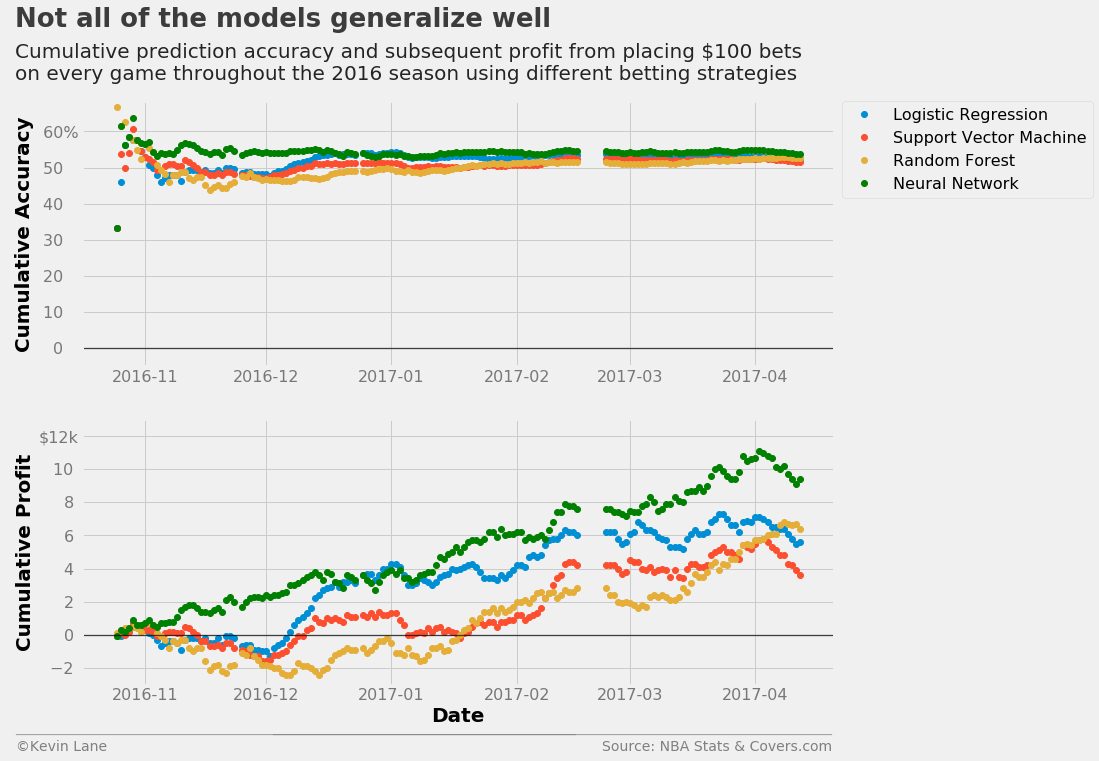

In [10]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(211)
ax1.plot_date(days_log, per_log*100, label='Logistic Regression')
ax1.plot_date(days_svm, per_svm*100, label='Support Vector Machine')
ax1.plot_date(days_rf, per_rf*100, label='Random Forest')
ax1.plot_date(days_mlp, per_mlp*100, label='Neural Network', color='green')
ax1.set_ylabel('Cumulative Accuracy')
ax1.set_ylim(-5)
ax1.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)

ax2 = plt.subplot(212)
ax2.plot_date(days_log, profit_log/1000)
ax2.plot_date(days_svm, profit_svm/1000)
ax2.plot_date(days_rf, profit_rf/1000)
ax2.plot_date(days_mlp, profit_mlp/1000, color='green')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Profit')
ax2.set_ylim(-3, 13)

title = 'Not all of the models generalize well'
subtitle = '''Cumulative prediction accuracy and subsequent profit from placing $100 bets
on every game throughout the 2016 season using different betting strategies'''
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.1, 1.01), yoff=(-1.38, -1.45), toff=(-.09, 1.28), soff=(-0.09, 1.08), 
           prefix = (' ', '$'), suffix=('%', 'k'), suffix_offset=(3, 1), n=80)
plt.show()

What is discouraging is that the logistic regression model performs worse than what was shown during [feature selection](feature-selection.md). The optimized hyperparameters do not necessarily generalize well because every season is different and presents unique intricacies. The code below retrains the models with default parameters. The logistic regression profits improve dramatically to what they were in the [feature selection](feature-selection.md) process, but the neural network performs drastically worse and ends up losing money.

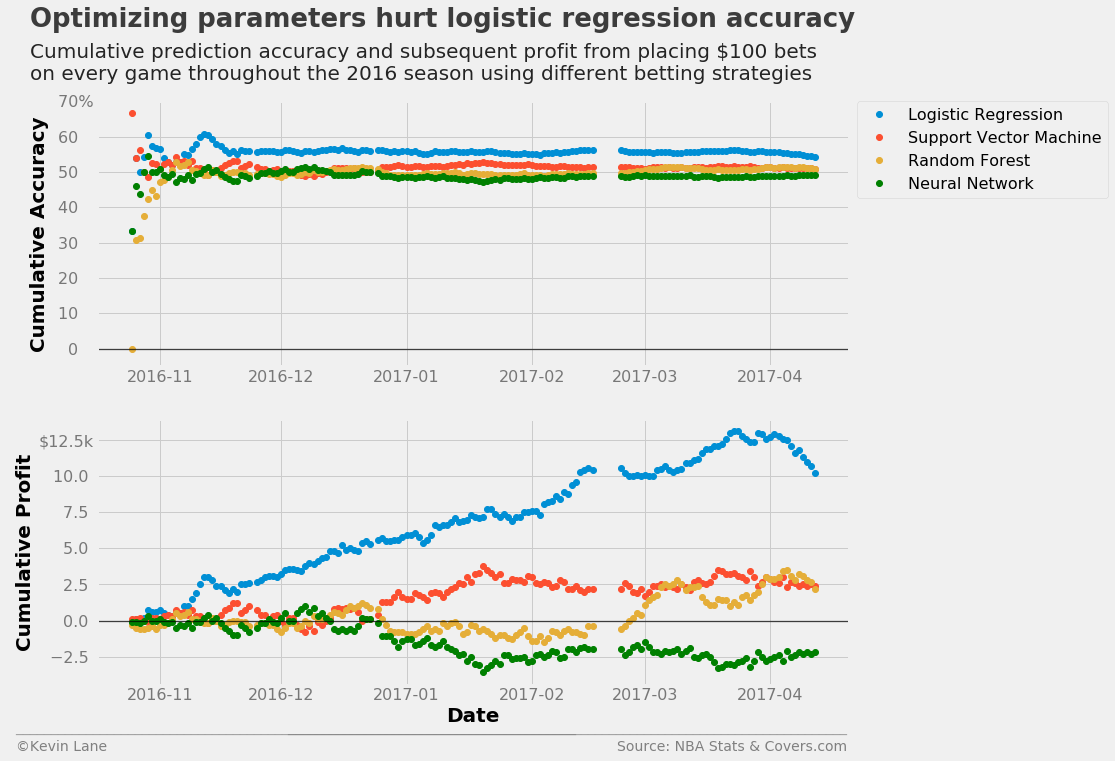

In [11]:
model = LogisticRegression()
output_log_df = simulate(model, games, 2016, stats, var_predict)
days_log_df, per_log_df, profit_log_df = profit(output_log_df, var_predict=var_predict, bet_amount=100)

model = LinearSVC()
output_svm_df = simulate(model, games, 2016, stats, var_predict)
days_svm_df, per_svm_df, profit_svm_df = profit(output_svm_df, var_predict=var_predict, bet_amount=100)

model = RandomForestClassifier(random_state=8)
output_rf_df = simulate(model, games, 2016, stats, var_predict)
days_rf_df, per_rf_df, profit_rf_df = profit(output_rf_df, var_predict=var_predict, bet_amount=100)

model = MLPClassifier(random_state=8)
output_mlp_df = simulate(model, games, 2016, stats, var_predict)
days_mlp_df, per_mlp_df, profit_mlp_df = profit(output_mlp_df, var_predict=var_predict, bet_amount=100)

fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(211)
ax1.plot_date(days_log_df, per_log_df*100, label='Logistic Regression')
ax1.plot_date(days_svm_df, per_svm_df*100, label='Support Vector Machine')
ax1.plot_date(days_rf_df, per_rf_df*100, label='Random Forest')
ax1.plot_date(days_mlp_df, per_mlp_df*100, label='Neural Network', color='green')
ax1.set_ylabel('Cumulative Accuracy')
ax1.set_ylim(-5)
ax1.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)

ax2 = plt.subplot(212)
ax2.plot_date(days_log_df, profit_log_df/1000)
ax2.plot_date(days_svm_df, profit_svm_df/1000)
ax2.plot_date(days_rf_df, profit_rf_df/1000)
ax2.plot_date(days_mlp_df, profit_mlp_df/1000, color='green')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Profit')

title = 'Optimizing parameters hurt logistic regression accuracy'
subtitle = '''Cumulative prediction accuracy and subsequent profit from placing $100 bets
on every game throughout the 2016 season using different betting strategies'''
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.12, 1.01), yoff=(-1.38, -1.45), toff=(-.09, 1.28), soff=(-0.09, 1.08), 
           prefix = (' ', '$'), suffix=('%', 'k'), suffix_offset=(3, 1), n=80)
plt.show()

# Model Retraining

All the predictions above do not use any data from the 2016 season, even by the end of the season. The simulate function has an option to evolve the model, which involves adding games from the test set (the 2016 season in this case) to the training set and retraining the model. The code below retrains logistic regression models using both the default and optimized hyperparameters at the end of each day of the season. The evolution has little impact on the model with default parameters, but cut profits for the model with optimized hyperparameters by about half.

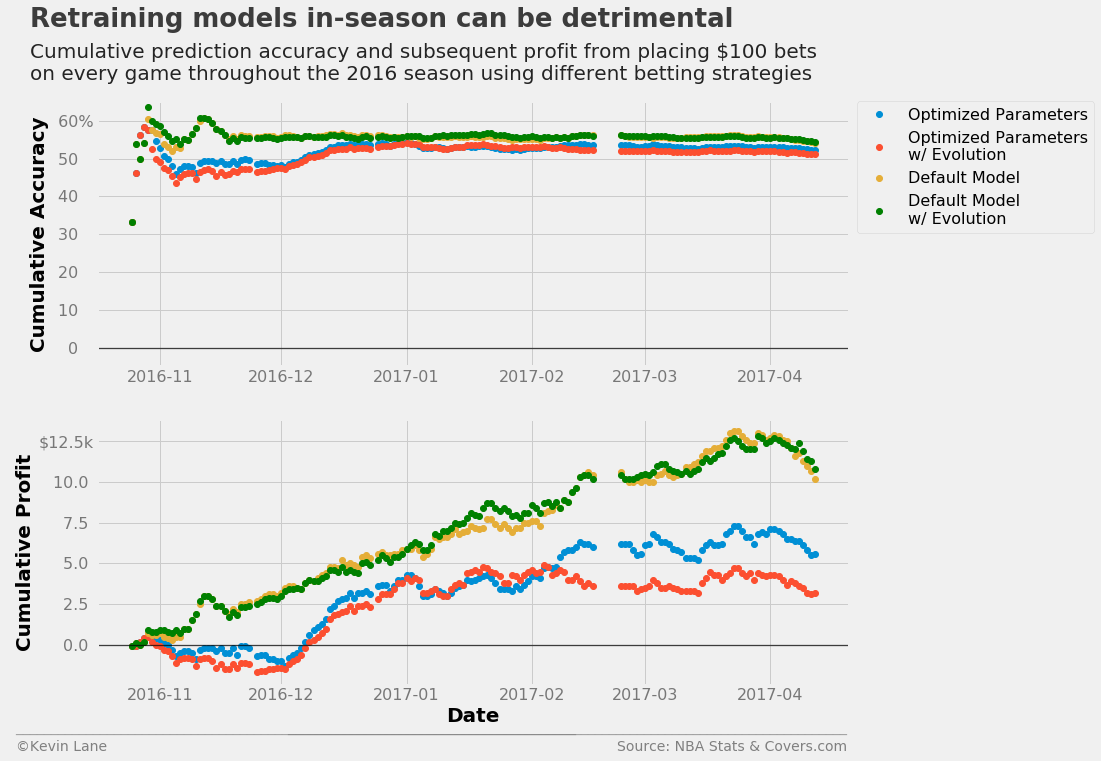

In [12]:
model = LogisticRegression(C=0.0001943920615336294, penalty='l2',
                           fit_intercept=True, intercept_scaling=134496.71823111628)
output_log_evo = simulate(model, games, 2016, stats, var_predict, evolve=True)
days_log_evo, per_log_evo, profit_log_evo = profit(output_log_evo, var_predict=var_predict, bet_amount=100)

model = LogisticRegression()
output_log_df_evo = simulate(model, games, 2016, stats, var_predict, evolve=True)
days_log_df_evo, per_log_df_evo, profit_log_df_evo = profit(output_log_df_evo, var_predict=var_predict,
                                                            bet_amount=100)

fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(211)
ax1.plot_date(days_log, per_log*100, label='Optimized Parameters')
ax1.plot_date(days_log_evo, per_log_evo*100, label='Optimized Parameters\nw/ Evolution')
ax1.plot_date(days_log_df, per_log_df*100, label='Default Model')
ax1.plot_date(days_log_df_evo, per_log_df_evo*100, label='Default Model\nw/ Evolution', color='green')
ax1.set_ylabel('Cumulative Accuracy')
ax1.set_ylim(-5)
ax1.legend(fontsize=16, bbox_to_anchor=(1.01, 1), borderaxespad=0)

ax2 = plt.subplot(212)
ax2.plot_date(days_log, profit_log/1000)
ax2.plot_date(days_log_evo, profit_log_evo/1000)
ax2.plot_date(days_log_df, profit_log_df/1000)
ax2.plot_date(days_log_df_evo, profit_log_df_evo/1000, color='green')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Profit')

title = 'Retraining models in-season can be detrimental'
subtitle = '''Cumulative prediction accuracy and subsequent profit from placing $100 bets
on every game throughout the 2016 season using different betting strategies'''
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.12, 1.01), yoff=(-1.38, -1.45), toff=(-.09, 1.28), soff=(-0.09, 1.08), 
           prefix = (' ', '$'), suffix=('%', 'k'), suffix_offset=(3, 1), n=80)
plt.show()